# Imports

In [15]:
import numpy as np
import pandas as pd
import xlsxwriter
import warnings
import matplotlib.pyplot as plt
import pandas_datareader as dr
import seaborn as sns
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model

%matplotlib inline

In [16]:
# df = Dataframe with an index and a value column
# title = Title of data being used
# xlab = Label of df.index
# ylab = Label of df.values
# seasonal_periods = The repetition cycle

previousStepsToShow = 15;

#stepsToForecast = [1, 3, 12];
#df = dr.DataReader('CPIAUCSL', "fred", start='1947-01-01', end='2019-09-01')
#df_train = df[['CPIAUCSL']][:-stepsToForecast[-1]].rename(columns={'CPIAUCSL': 'train'})
#df_test = df[['CPIAUCSL']][-stepsToForecast[-1]:].rename(columns={'CPIAUCSL': 'test'})
#title = 'CPIAUC'
# Label of df.index
#xlab = 'Months/Year'; 
# Label of df.values
#ylab = 'CPI: Index 1982-1984=100 (Seasonally Adjusted)';
#seasonal_periods = 12

#stepsToForecast = [1, 5, 21];
#df = pd.read_csv("PSI_20_Data_1992_Stooq.csv") 
#df = pd.DataFrame(df, columns= ['Date','Close'])
#df.set_index('Date', drop=True, inplace=True)
#df.index = pd.to_datetime(df.index)
#df = df.truncate(before='2002-01-01', after='2019-09-27')
#df_train = df[['Close']][:-stepsToForecast[-1]].rename(columns={'Close': 'train'})
#df_test = df[['Close']][-stepsToForecast[-1]:].rename(columns={'Close': 'test'})
#title = 'PSI20: Historical Closing Prices'
#xlab = 'Working Days/Year'; 
#ylab = 'Closing Price (\x80)'.decode("windows-1252");
#seasonal_periods = 5

stepsToForecast = [1, 5, 21];
df = dr.data.get_data_yahoo('SPY', start= '1993-01-01', end='2019-09-27')
df_train = df[['Close']][:-stepsToForecast[-1]].rename(columns={'Close': 'train'})
df_test = df[['Close']][-stepsToForecast[-1]:].rename(columns={'Close': 'test'})
title = 'SP500'
xlab = 'Days/Year'; 
ylab = 'Closing Price ($)';
seasonal_periods=5;

#stepsToForecast = [1, 3, 12];
#df = dr.DataReader("TRFVOLUSM227NFWA", "fred", start="1947-01-01", end="2019-09-01")
#df_train = df[['TRFVOLUSM227NFWA']][:-stepsToForecast[-1]].rename(columns={'TRFVOLUSM227NFWA': 'train'})
#df_test = df[['TRFVOLUSM227NFWA']][-stepsToForecast[-1]:].rename(columns={'TRFVOLUSM227NFWA': 'test'})
#title = "Vehicle Miles Traveled";
#xlab = "Months/Year";
#ylab = "Millions of Miles";
#seasonal_periods = 12

# Define Functions

In [4]:
def split_train_cv_test_forwardChaining(sequence, n_steps_input, n_steps_forecast, n_steps_jump):
    X, y, Xcv, ycv, Xtest, ytest = dict(), dict(), dict(), dict(), dict(), dict()
    j=2; # Tracks index of CV set at each train/val/test split
    
    # Iterate through all train/val/test splits
    while 1:
        start_ix=0; end_ix=0; startCv_ix=0; endCv_ix=0; startTest_ix=0; endTest_ix=0;
        X_it, y_it, Xcv_it, ycv_it, Xtest_it, ytest_it = list(), list(), list(), list(), list(), list()
        i=0; # Index of individual training set at each train/val/test split
        
        # Iterate until index of individual training set is smaller than index of cv set
        while (i < j):
            ## TRAINING DATA
            start_ix = n_steps_jump*i;
            end_ix = start_ix + n_steps_input;
            
            seq_x = sequence[start_ix:end_ix] 
            X_it.append(seq_x)
            seq_y = sequence[end_ix:end_ix+n_steps_forecast]
            y_it.append(seq_y)
            
            i+=1;
          
        # Once test data crosses time series length return   
        if ((((end_ix+n_steps_input)+n_steps_input)+n_steps_forecast) > (len(sequence))):
            break
        
        ## CROSS-VALIDATION DATA
        startCv_ix = end_ix;
        endCv_ix = end_ix + n_steps_input;
        
        seq_xcv = sequence[startCv_ix:endCv_ix] 
        Xcv_it.append(seq_xcv)
        seq_ycv = sequence[endCv_ix:endCv_ix+n_steps_forecast]
        ycv_it.append(seq_ycv) 
        
        ## TEST DATA
        startTest_ix = endCv_ix;
        endTest_ix = endCv_ix + n_steps_input;
        
        seq_xtest = sequence[startTest_ix:endTest_ix] 
        Xtest_it.append(seq_xtest)
        seq_ytest = sequence[endTest_ix:endTest_ix+n_steps_forecast]
        ytest_it.append(seq_ytest) 
            
        ## Add another train/val/test split 
        X[j-2] = np.array(X_it)
        y[j-2] = np.array(y_it)
        Xcv[j-2] = np.array(Xcv_it)
        ycv[j-2] = np.array(ycv_it)
        Xtest[j-2] = np.array(Xtest_it)
        ytest[j-2] = np.array(ytest_it)
        
        j+=1;
            
    return X, y, Xcv, ycv, Xtest, ytest

In [5]:
def split_sequence(sequence, n_steps_input, stepsToForecast, n_steps_jump):
    X, y = list(), list()
    for i in range(len(sequence)):
        i = n_steps_jump*i;
        # Descobrir o indice da ultima amostra
        end_ix = i + n_steps_input
        # Se tivermos chegado ao fim da serie paramos
        if end_ix+stepsToForecast > len(sequence):
            break
        # Extrai training/testing data
        seq_x = sequence[i:end_ix] 
        X.append(seq_x)
        seq_y = sequence[end_ix:end_ix+stepsToForecast]
        y.append(seq_y)
    return np.array(X), np.array(y)

In [6]:
# Define Mean Absolute Percentage Error
def printMAEpred(y_true, y_pred, horizonSteps):
    ae  = abs(y_pred - y_true);
    ape = 100*(abs(y_pred - y_true) / y_true);
    for i in horizonSteps:
        print('Prediction for ' + str(i) + ' ' + xlab + ': MAE = ' + str(round(np.mean(ae[:i]), 2)) + ' (' + str(round(np.mean(ape[:i]), 2)) + '%)'  )

# Train NN

## Pre-Processing and Model Selection

In [17]:
## ------- PRE PROCESSING -------
series_input = df_train.values[-500:]

## ------- MODEL -------
# Select between 'MLP', 'RNN', or 'LSTM'
NN_str = 'MLP'

n_steps_input = 84
n_steps_jump = 5

train_epochs = 100

model = Sequential()
if (NN_str == 'MLP'):
    model.add(Dense(200, activation='relu', input_dim=n_steps_input)) #podemos metre mais camadas, as que se quiser
    model.add(Dense(stepsToForecast[-1], activation='linear'))
    model.compile( optimizer='adam', loss='mse', metrics=['mean_absolute_percentage_error'])
elif (NN_str == 'RNN'):
    model.add(SimpleRNN(100, input_shape=(n_steps_input, 1), activation='relu', return_sequences=True))    
    model.add(SimpleRNN(10, activation='relu', return_sequences=False))
    model.add(Dense(stepsToForecast[-1]))
    model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_percentage_error'])
else:
    model.add(LSTM(100,input_shape=(n_steps_input, 1), dropout=0.2, activation='relu', return_sequences=True))  
    model.add(LSTM(30, activation='relu', dropout=0.1, return_sequences=True))
    model.add(LSTM(10, dropout=0.2, return_sequences=False))
    model.add(Dense(stepsToForecast[-1]))
    model.compile(optimizer='adam', loss='mse')

## Cross-Validation - Select model

In [129]:
## ------- SPLIT IN TRAINING/VALIDATION DATA -------

# Select one of the following cross-validation methods
X_train, y_train, X_cv, y_cv, X_test, y_test = split_train_cv_test_forwardChaining(series_input, n_steps_input, stepsToForecast[-1], n_steps_jump)

dict_mae = {} 
for ix in np.arange(len(X_train)):
    
    print("%d/%d" % (ix+1, len(X_train)));
    
    if (NN_str == 'MLP'):
        X_train[ix] = np.squeeze(X_train[ix], axis=2)
        X_cv[ix] = np.squeeze(X_cv[ix], axis=2)
        X_test[ix] = np.squeeze(X_test[ix], axis=2)
    y_train[ix] = np.squeeze(y_train[ix], axis=2)
    y_cv[ix] = np.squeeze(y_cv[ix], axis=2)
    
    ## ------- TRAINING MODEL -------
    model.fit(X_train[ix], y_train[ix], epochs = train_epochs, verbose = 0);

    ## ------- TRAINING ERROR -------
    y_pred_train_t = model.predict(X_train[ix])
    y_train_t = y_train[ix]

    list_mae_train = list()
    for i in np.arange(len(y_train_t)):
        mae_train = mean_absolute_error(y_train_t[i,:], y_pred_train_t[i,:])
        list_mae_train.append(mae_train)
        
    ## ------- CROSS VALIDATION ERROR -------
    y_pred_cv_t = model.predict(X_cv[ix])
    y_cv_t = y_cv[ix]

    list_mae_cv = list()
    for i in np.arange(len(y_cv_t)):     
        mae_cv = mean_absolute_error(y_cv_t[i,: ], y_pred_cv_t[i,:])
        list_mae_cv.append(mae_cv)
        
    ## ------- TEST ERROR -------
    y_pred_test_t = model.predict(X_test[ix])
    y_test_t = y_test[ix]

    list_mae_test = list()
    for i in np.arange(len(y_test_t)):     
        mae_test = mean_absolute_error(y_test_t[i,: ], y_pred_test_t[i,:])
        list_mae_test.append(mae_test)
    
    dict_mae[str(ix)] = {'train': list_mae_train, 'cv': list_mae_cv, 'test': list_mae_test}

trainMae = np.mean([np.mean(dict_mae[str(runIx)]['train']) for runIx in np.arange(len(X_train))]);
cvMae = np.mean([np.mean(dict_mae[str(runIx)]['cv']) for runIx in np.arange(len(X_train))]);
testMae = np.mean([np.mean(dict_mae[str(runIx)]['test']) for runIx in np.arange(len(X_train))]);

1/45
2/45
3/45
4/45
5/45
6/45
7/45
8/45
9/45
10/45
11/45
12/45
13/45
14/45
15/45
16/45
17/45
18/45
19/45
20/45
21/45
22/45
23/45
24/45
25/45
26/45
27/45
28/45
29/45
30/45
31/45
32/45
33/45
34/45
35/45
36/45
37/45
38/45
39/45
40/45
41/45
42/45
43/45
44/45
45/45


## Cross-Validation Performance

In [145]:
## Assess Training / Cross-Validation / Test
# DEBUG_LEVEL = 0 - Only shows STATS of ALL runs
#               1 - Shows the average MAE through runs 
#               2 - Shows the MAE at each run at each train/cv/test set    

DEBUG_LEVEL = 0

print("STATS of ALL runs")    
print("Train avg MAE avg = %.4f" % trainMae) 
print("Cross-Validation avg MAE avg = %.4f" % cvMae)
print("Test avg MAE avg = %.4f" % testMae)

list_train_mae = list()
list_cv_mae = list()
list_test_mae = list()
for runIx in np.arange(len(X_train)):
    if (DEBUG_LEVEL > 0):
        print("")
        print("----- RUN NUMBER %d -----" % (runIx+1))

    list_train_mae.append(np.mean(dict_mae[str(runIx)]['train']))
    if (DEBUG_LEVEL > 0):
        print ("Train MAE avg = %.3f" % np.mean(dict_mae[str(runIx)]['train'])) 
        if (DEBUG_LEVEL > 1):
            if (len(dict_mae[str(runIx)]['train'])>1):
                print("Individual trains: " + str([round(x,4) for x in dict_mae[str(runIx)]['train']]))
    
    list_cv_mae.append(np.mean(dict_mae[str(runIx)]['cv']))
    if (DEBUG_LEVEL > 0):
        print ("Cross-Validation MAE avg = %.3f" % np.mean(dict_mae[str(runIx)]['cv'])) 
        if (DEBUG_LEVEL > 1):
            if (len(dict_mae[str(runIx)]['cv'])>1):
                print("Individual cross-validations: " + str([round(x,4) for x in dict_mae[str(runIx)]['cv']]))
            
    list_test_mae.append(np.mean(dict_mae[str(runIx)]['test']))
    if (DEBUG_LEVEL > 0):
        print ("Test MAE avg = %.3f" % np.mean(dict_mae[str(runIx)]['test'])) 
        if (DEBUG_LEVEL > 1):
            if (len(dict_mae[str(runIx)]['test'])>1):
                print("Individual tests: " + str([round(x,4) for x in dict_mae[str(runIx)]['test']]))

STATS of ALL runs
Train avg MAE avg = 4.9851
Cross-Validation avg MAE avg = 7.3368
Test avg MAE avg = 9.5701


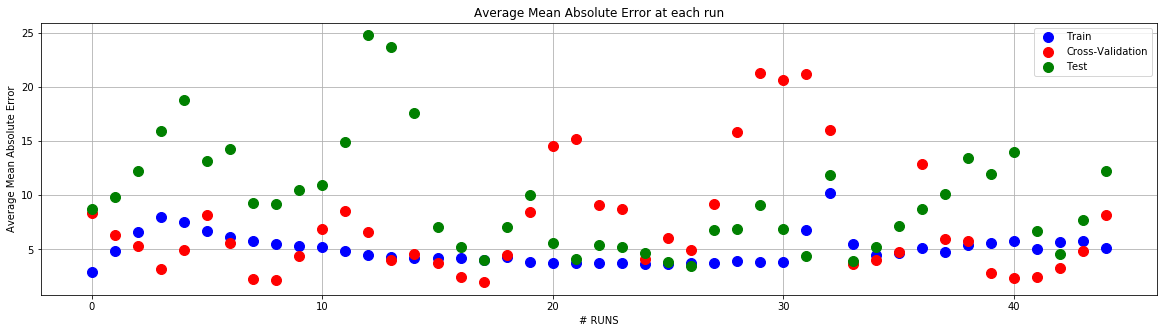

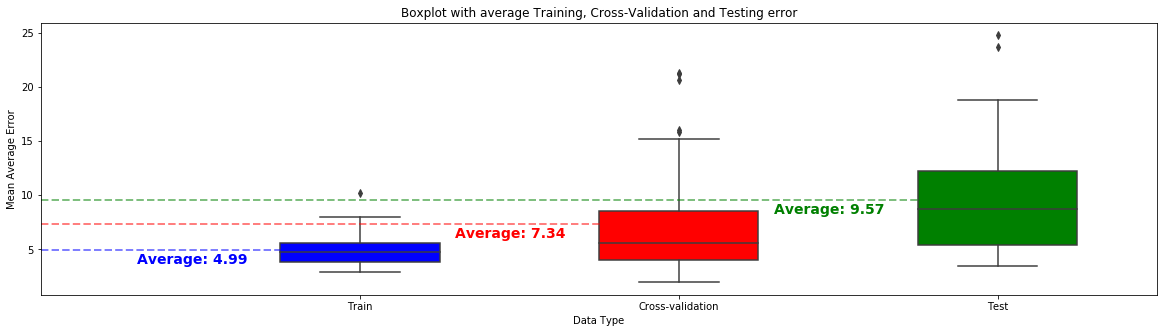

In [152]:
# Plot Mean Absolute Errors of each run
plt.figure(figsize=(20,5))
plt.plot(list_train_mae, 'bo', markersize=10, label = 'Train')
plt.plot(list_cv_mae, 'ro', markersize=10, label = 'Cross-Validation')
plt.plot(list_test_mae, 'go', markersize=10, label = 'Test')
plt.legend()
plt.xlabel('# RUNS')
plt.ylabel('Average Mean Absolute Error')
plt.title('Average Mean Absolute Error at each run')
plt.grid()

# Plot Mean Absolute Errors of each run
x_bp = np.concatenate((np.repeat('Train', len(list_train_mae)), \
                       np.repeat('Cross-validation', len(list_cv_mae)), 
                       np.repeat('Test', len(list_test_mae))), axis = 0)

y_bp = np.concatenate((list_train_mae, \
                       list_cv_mae, \
                       list_test_mae), axis = 0)

df_bp = pd.DataFrame(data={'Data Type': x_bp, 'Mean Average Error': y_bp})

plt.figure(figsize=(20, 5))
bplot=sns.boxplot(y='Mean Average Error', x='Data Type', data=df_bp, width=0.5)
bplot.artists[0].set_facecolor('blue')
bplot.artists[1].set_facecolor('red')
bplot.artists[2].set_facecolor('green')
plt.title('Boxplot with average Training, Cross-Validation and Testing error');
plt.plot([-1,0], [trainMae, trainMae],'b--', lw=2, alpha=0.5)
plt.plot([-1,1], [cvMae, cvMae],'r--', lw=2, alpha=0.5)
plt.plot([-1,2], [testMae, testMae],'g--', lw=2, alpha=0.5)
plt.xlim([-1, 2.5])
plt.text(-0.70, trainMae-1.3, 'Average: ' + str(round(trainMae,2)), fontsize=14, color='b', fontweight='bold')
plt.text(0.30, cvMae-1.3, 'Average: ' + str(round(cvMae,2)), fontsize=14, color='r', fontweight='bold')
plt.text(1.30, testMae-1.3, 'Average: ' + str(round(testMae,2)), fontsize=14, color='g', fontweight='bold')
plt.show()

## Model prediction

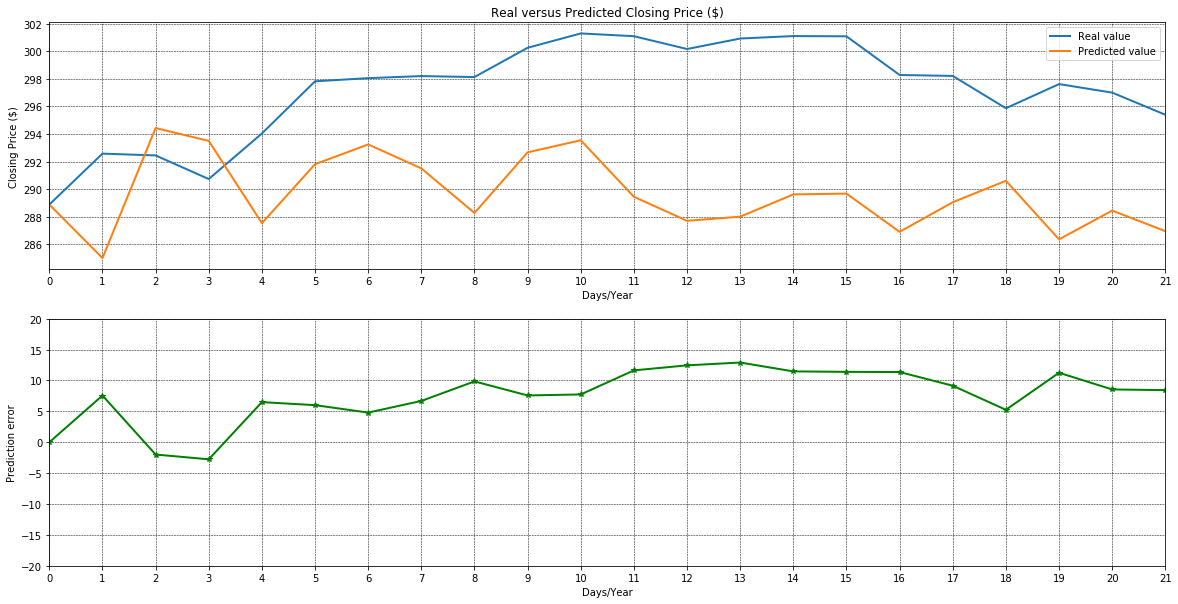

Prediction for 1 Days/Year: MAE = 7.57 (2.59%)
Prediction for 5 Days/Year: MAE = 4.96 (1.69%)
Prediction for 21 Days/Year: MAE = 8.35 (2.8%)


In [25]:
X_test, y_test = split_sequence(series_input, n_steps_input, stepsToForecast[-1], n_steps_jump)
if (NN_str == 'MLP'):
    X_test = np.squeeze(X_test, axis=2)
y_test = np.squeeze(y_test, axis=2)

## ------- TRAIN MODEL WITH ALL DATA-------
model.fit(X_test, y_test, epochs = train_epochs, verbose = 0);

if (NN_str == 'MLP'):
    yhat = model.predict(series_input[-n_steps_input:].T, verbose=0)
else:
    yhat = model.predict(series_input[-n_steps_input:].reshape(1, n_steps_input, 1), verbose=0)

#plt.plot()
y_pred_test = yhat.tolist()

predictions_array = np.array(y_pred_test).flatten()
    
real_array = np.array(df_test.values).flatten()

# plot results
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.title('Real versus Predicted ' + ylab)
plt.plot(range(0,len(real_array)+1), np.concatenate((series_input[-1], real_array), axis=0), linewidth=2)
plt.plot(range(0,len(predictions_array)+1), np.concatenate((series_input[-1], predictions_array), axis=0), linewidth=2)
plt.xlim([0,len(predictions_array)])
plt.xticks(np.arange(0, len(predictions_array)+1, step=1))
plt.grid(color='k', linestyle='--', linewidth=.5)
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.legend(['Real value', 'Predicted value'])

plt.subplot(212)
plt.plot(range(0,len(real_array-predictions_array)+1), np.concatenate((np.array([0]), real_array-predictions_array), axis=0), 'g-*', linewidth=2)
plt.xticks(np.arange(0, len(predictions_array)+1, step=1))
plt.xlim([0,len(predictions_array)])
plt.xlabel(xlab)
plt.ylabel('Prediction error')
plt.grid(color='k', linestyle='--', linewidth=.5)
plt.show()

printMAEpred(real_array, predictions_array, stepsToForecast)

NameError: name 'dict_mae' is not defined